# OsmGt example

## Imports and prepare input parameters

In [1]:
from IPython.display import display

from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.ops import linemerge

from gdf2bokeh import Gdf2Bokeh

from osmgt import OsmGt

from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

## Get POIs

In [2]:
%%time

pois_gdf = OsmGt.pois_from_location(location).get_gdf()

display(pois_gdf.head(2))

2022-05-27 13:43:06 - OsmGtPoi        - INFO     : From location: Roanne
2022-05-27 13:43:06 - OsmGtPoi        - INFO     : Loading data...
2022-05-27 13:43:07 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 1.14 sec.
2022-05-27 13:43:11 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 3.9 sec.
2022-05-27 13:43:11 - OsmGtPoi        - INFO     : Formating data
2022-05-27 13:43:11 - OsmGtPoi        - INFO     : Prepare GeoDataframe
2022-05-27 13:43:11 - OsmGtPoi        - INFO     : GeoDataframe Ready


addr:postcode           amenity  atm change_machine               name  \
0         42300       post_office  yes            yes   Roanne Principal   
1           NaN  place_of_worship  NaN            NaN  Chapelle Jean Puy   

                                       opening_hours  operator  \
0  Mo,We-Fr 08:30-18:00; Tu 08:30-12:00,13:45-18:...  La Poste   
1                                                NaN       NaN   

  operator:wikidata                  operator:wikipedia phone  ...  \
0           Q373724  fr:La Poste (entreprise française)  3631  ...   
1               NaN                                 NaN   NaN  ...   

  source:opening_hours clothes waste office second_hand recycling:cartons  \
0                  NaN     NaN   NaN    NaN         NaN               NaN   
1                  NaN     NaN   NaN    NaN         NaN               NaN   

   recycling:plastic_packaging indoor post_box:type                  geometry  
0                          NaN    NaN           NaN  POINT (4.07225 46.04071)  
1                          NaN    NaN           NaN  POINT (4.07073 46.03766)  

[2 rows x 134 columns]

CPU times: user 245 ms, sys: 13.8 ms, total: 259 ms
Wall time: 5.15 s


## Get Roads

In [3]:
%%time
roads_initialized = OsmGt.roads_from_location(
    location,
    mode="vehicle",
    additional_nodes=pois_gdf
)
roads_gdf = roads_initialized.get_gdf()

display(roads_gdf.head(2))

2022-05-27 13:43:11 - OsmGtRoads      - INFO     : From location: Roanne
2022-05-27 13:43:11 - OsmGtRoads      - INFO     : Loading data...
2022-05-27 13:43:12 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0.24 sec.
2022-05-27 13:43:17 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 5.43 sec.
2022-05-27 13:43:17 - OsmGtRoads      - INFO     : Rebuild network data
2022-05-27 13:43:17 - OsmGtRoads      - INFO     : Network cleaning...
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Find nearest line for each node
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Split line
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Topology lines checker: to add: 314, to split: 309
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Starting: Find intersections
2022-05-27 13:43:18 - OsmGtRoads      - INFO     : Done: Find intersections
2022-05-27 13:43:18 - OsmGtRoads      - 

topo_uuid        id oneway   topology  \
0   1_forward  24035569    yes  unchanged   
1  1_backward  24035569    yes  unchanged   

                                            geometry  
0  LINESTRING (4.08544 46.05234, 4.08546 46.05248...  
1  LINESTRING (4.08553 46.05271, 4.08546 46.05248...

CPU times: user 1.78 s, sys: 41.4 ms, total: 1.82 s
Wall time: 7.55 s


## Display roads and nodes

In [4]:
%%time
layers_to_add = [
    {
        "input_gdf": roads_gdf,
        "legend": "roads",
        "color": "black",
    },
    {
        "input_gdf": pois_gdf,
        "legend": "POIs",
        "color": "blue",
        "size": 9
    },
]



my_map = Gdf2Bokeh(
    "My roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
# print(dir(my_map))
# print(my_map._Gdf2Bokeh__BOKEH_LAYER_CONTAINERS)



show(my_map.figure)

CPU times: user 3.47 s, sys: 5.65 ms, total: 3.48 s
Wall time: 3.49 s


## Check topology details

In [5]:
%%time

roads_topology_gdfs = roads_initialized.topology_checker()

lines_unchanged = roads_topology_gdfs["lines_unchanged"]
lines_added = roads_topology_gdfs["lines_added"]
lines_split = roads_topology_gdfs["lines_split"]
nodes_added = roads_topology_gdfs["nodes_added"]
intersections_added = roads_topology_gdfs["intersections_added"]

layers_to_add = [
    {
        "input_gdf": lines_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": lines_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": lines_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": intersections_added,
        "legend": "Intersections added",
        "color": "brown",
    },
    {
        "input_gdf": nodes_added,
        "legend": "Nodes added",  # POIs here
        "style": "square",
        "color": "blue",
        "size": 9
    },
]

my_map = Gdf2Bokeh(
    "Topology about my roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_map.figure)

2022-05-27 13:43:22 - OsmGtRoads      - INFO     : Prepare topology data
2022-05-27 13:43:23 - OsmGtRoads      - INFO     : GeoDataframe Ready


CPU times: user 5.65 s, sys: 23.3 ms, total: 5.67 s
Wall time: 5.68 s


## Get the graph-tool network and display it

2022-05-27 13:43:28 - OsmGtRoads      - INFO     : Prepare graph
2022-05-27 13:43:30 - OsmGtRoads      - INFO     : Graph ok
2022-05-27 13:43:30 - OsmGtRoads      - INFO     : Graph to image


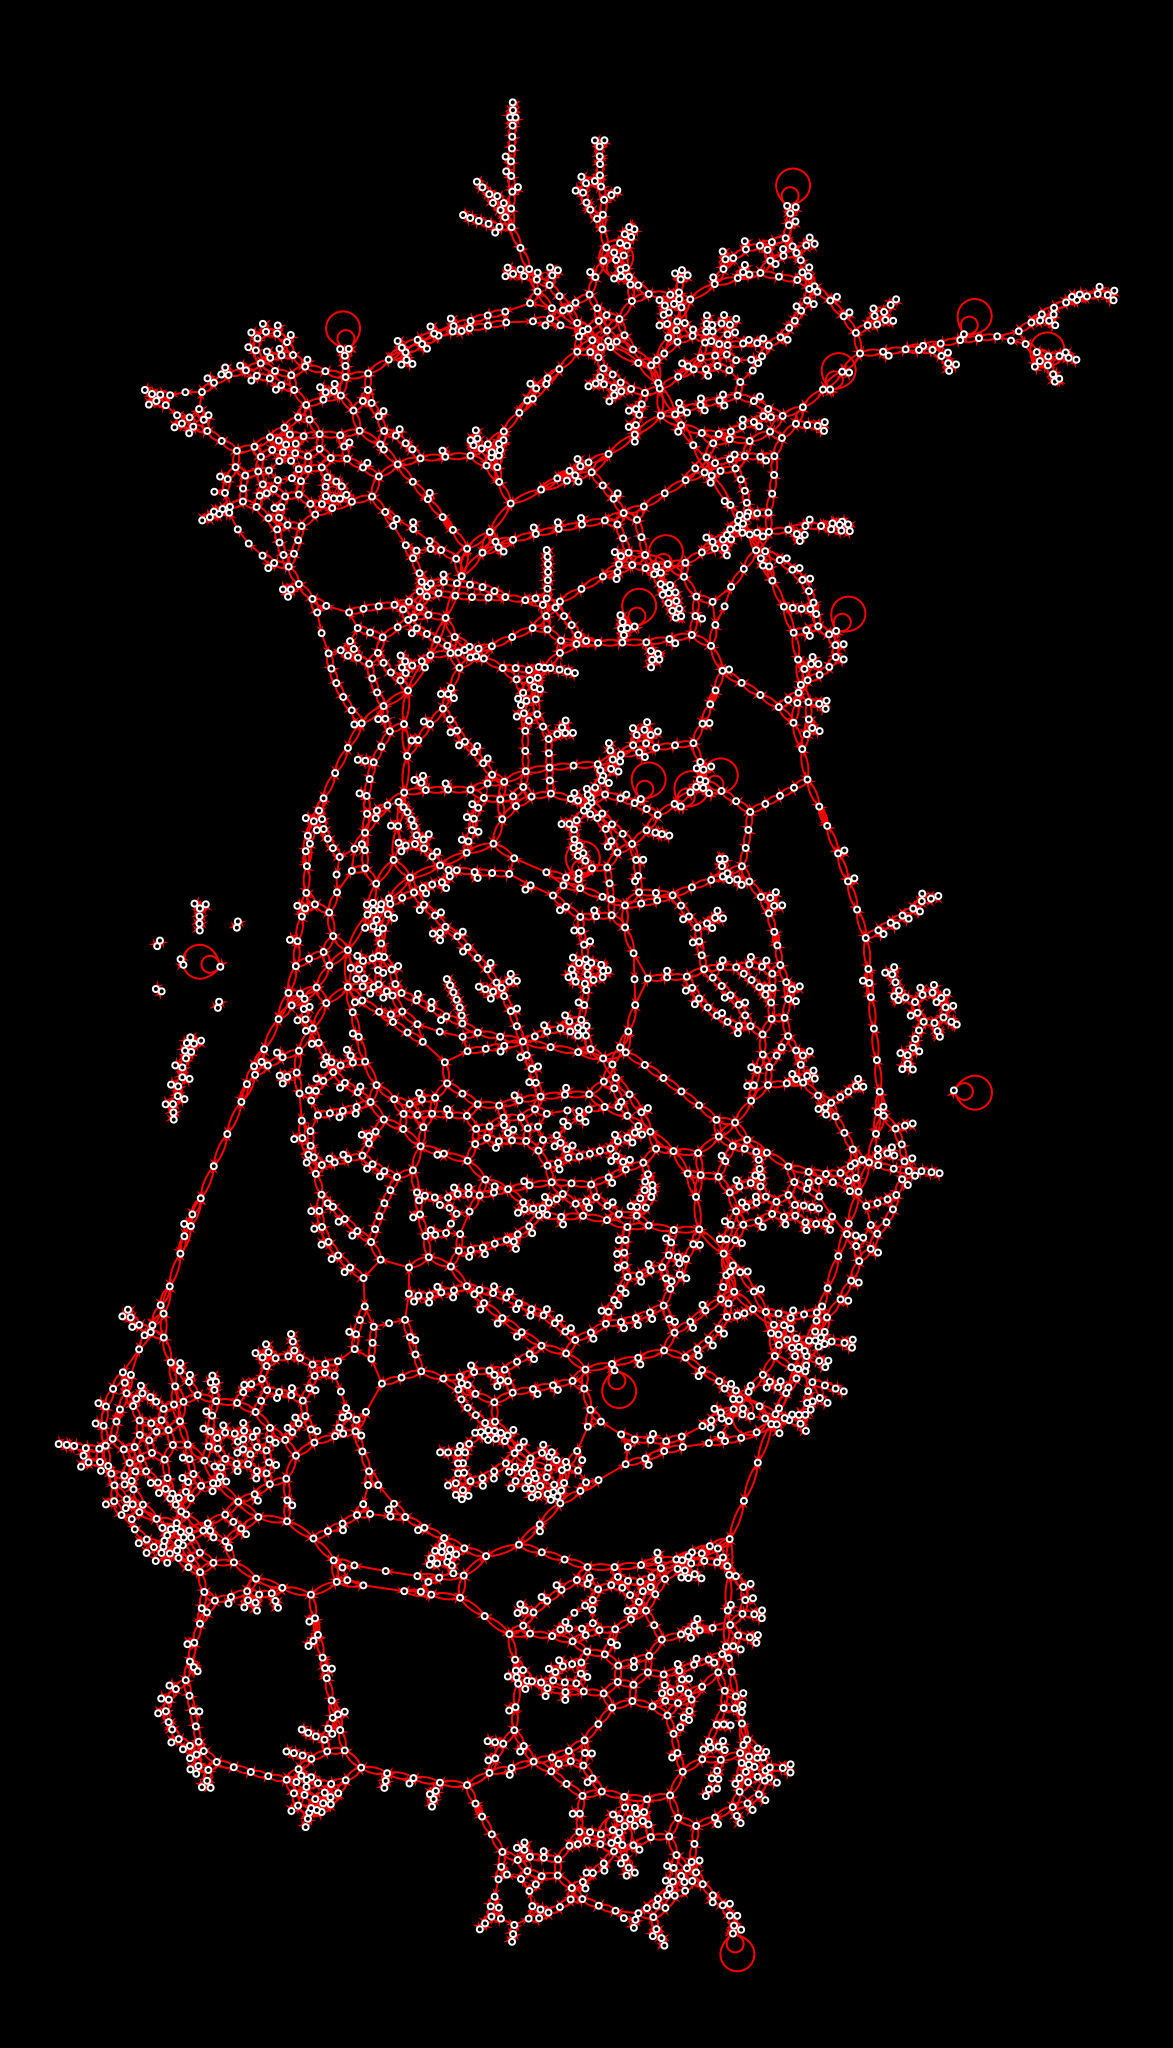

CPU times: user 27.2 s, sys: 98.6 ms, total: 27.3 s
Wall time: 9.34 s


In [6]:
%%time
graph = roads_initialized.get_graph()

# a plot method has been added on OsmGT.
graph.plot()

## Compute a shortest path 

### With graph-tools function

In [8]:
%%time
# now, we have to define a start point and a end point and get their wkt
start_node_topo_uuid = 47
end_node_topo_uuid = 63

# 'topo_uuid' is generated by osmgt (during the topology processing).
# Some roads has been split that's whyso this id has been created.
start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node_wkt = start_node_gdf.iloc[0]["geometry"].wkt
end_node_wkt = end_node_gdf.iloc[0]["geometry"].wkt

# the graph have some methods (graph-tools method always exists!) to find egdes, vertices... Let's use the .find_vertex_from_name(). the wkt is the vertex name...
source_vertex = graph.find_vertex_from_name(start_node_wkt)
target_vertex = graph.find_vertex_from_name(end_node_wkt)

# shortest path computing...
path_vertices, path_edges = shortest_path(
    graph,
    source=source_vertex,
    target=target_vertex,
    weights=graph.edge_weights  # weigth is based on line length
)

# get path by using edge names
roads_ids = [
    graph.edge_features[edge]
    for edge in path_edges
]

roads_gdf_copy = roads_gdf.copy(deep=True)
shortest_path_found = roads_gdf_copy[roads_gdf['topo_uuid'].isin(roads_ids)].to_crs(3857)['geometry'].to_list()
shortest_path_found_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[linemerge(shortest_path_found)])

layers_to_add = [
    {
        "input_gdf": shortest_path_found_gdf,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 208 ms, sys: 3.95 ms, total: 212 ms
Wall time: 216 ms


### With OsmGt function

In [9]:
%%time

start_node_topo_uuid = 47
end_node_topo_uuid = 63

start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node = start_node_gdf.iloc[0]["geometry"]
end_node = end_node_gdf.iloc[0]["geometry"]

shortest_paths = OsmGt.shortest_path_from_location(
    "Roanne",
    [
        (start_node, end_node),
        (start_node, end_node),  # duplicate pairs are cleaned
    ],
    mode="pedestrian"
)
layers_to_add = [
    {
        "input_gdf": shortest_paths[["geometry"]],
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

display(shortest_paths)

2022-05-27 13:44:35 - OsmGtShortestPath - INFO     : Shortest path processing...
2022-05-27 13:44:35 - OsmGtShortestPath - INFO     : From location: Roanne
2022-05-27 13:44:35 - OsmGtShortestPath - INFO     : Loading data...
2022-05-27 13:44:36 - OsmGtShortestPath - INFO     : NominatimApi: Query 200:OK in 0.31 sec.
2022-05-27 13:44:39 - OsmGtShortestPath - INFO     : OverpassApi: Query 200:OK in 3.58 sec.
2022-05-27 13:44:39 - OsmGtShortestPath - INFO     : Rebuild network data
2022-05-27 13:44:39 - OsmGtShortestPath - INFO     : Network cleaning...
2022-05-27 13:44:40 - OsmGtShortestPath - INFO     : Starting: Adding new nodes on the network
2022-05-27 13:44:40 - OsmGtShortestPath - INFO     : Find nearest line for each node
2022-05-27 13:44:40 - OsmGtShortestPath - INFO     : Split line
2022-05-27 13:44:40 - OsmGtShortestPath - INFO     : Topology lines checker: to add: 2, to split: 2
2022-05-27 13:44:40 - OsmGtShortestPath - INFO     : Starting: Find intersections
2022-05-27 13:44:

source_node                  target_node  \
0  POINT (4.053432 46.024165)  POINT (4.0775424 46.046573)   

                                             osm_ids  \
0  120171169, 120171186, 122371009, 122371019, 12...   

                                            geometry id  
0  LINESTRING (4.05343 46.02417, 4.05338 46.02393...  0

CPU times: user 2.12 s, sys: 7.88 ms, total: 2.13 s
Wall time: 6.1 s


## Compute an isochrone

### Isochrone from times

In [10]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    1: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_lines_values = {
    1: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 0.5  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_times_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_name"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_name"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2022-05-27 13:44:50 - OsmGtIsochrone  - INFO     : Isochrone processing...
2022-05-27 13:44:50 - OsmGtIsochrone  - INFO     : From bbox: (4.065331739709741, 46.03137925848238, 4.076676960290258, 46.03862976056118)
2022-05-27 13:44:50 - OsmGtIsochrone  - INFO     : Loading data...
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.37 sec.
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Rebuild network data
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Network cleaning...
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Split line
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2022-05-27 13:44:51 - OsmGtIsochrone  - INFO     : Done: Find intersec

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='1949', ...)



Isochrones polygons output


iso_name time_unit  iso_distance distance_unit  \
0         10   minutes            84        meters   
1         10   minutes            84        meters   
2         10   minutes            84        meters   
3         10   minutes            84        meters   
4         10   minutes            84        meters   
5         10   minutes            84        meters   
6         10   minutes            84        meters   
7         10   minutes            84        meters   
8         10   minutes            84        meters   
9         10   minutes            84        meters   
10        10   minutes            84        meters   
11         5   minutes            42        meters   
12         5   minutes            42        meters   
13         5   minutes            42        meters   
14         5   minutes            42        meters   
15         5   minutes            42        meters   
16         1   minutes             9        meters   
17         1   minutes             9        meters   

                                             geometry  id    color  
0   POLYGON ((4.06590 46.03664, 4.06592 46.03660, ...   0  #f46d43  
1   POLYGON ((4.06632 46.03690, 4.06632 46.03690, ...   1  #f46d43  
2   POLYGON ((4.06624 46.03691, 4.06624 46.03691, ...   2  #f46d43  
3   POLYGON ((4.06618 46.03693, 4.06618 46.03693, ...   3  #f46d43  
4   POLYGON ((4.06613 46.03694, 4.06613 46.03694, ...   4  #f46d43  
5   POLYGON ((4.06611 46.03694, 4.06613 46.03694, ...   5  #f46d43  
6   POLYGON ((4.06606 46.03695, 4.06606 46.03695, ...   6  #f46d43  
7   POLYGON ((4.07251 46.03174, 4.07255 46.03173, ...   7  #f46d43  
8   POLYGON ((4.06661 46.03683, 4.06646 46.03686, ...   8  #f46d43  
9   POLYGON ((4.06633 46.03689, 4.06634 46.03689, ...   9  #f46d43  
10  POLYGON ((4.07571 46.03798, 4.07577 46.03801, ...  10  #f46d43  
11  POLYGON ((4.07184 46.03203, 4.07199 46.03183, ...  11  #fee08b  
12  POLYGON ((4.06664 46.03671, 4.06665 46.03672, ...  12  #fee08b  
13  POLYGON ((4.06630 46.03681, 4.06624 46.03682, ...  13  #fee08b  
14  POLYGON ((4.07576 46.03797, 4.07576 46.03797, ...  14  #fee08b  
15  POLYGON ((4.07566 46.03800, 4.07566 46.03800, ...  15  #fee08b  
16  POLYGON ((4.06631 46.03682, 4.06631 46.03682, ...  16  #d9ef8b  
17  POLYGON ((4.07181 46.03202, 4.07181 46.03202, ...  17  #d9ef8b


Isochrones lines output


topo_uuid         id oneway topology  iso_name  iso_distance  \
105  155_0105  586846030    NaN    split      10.0          84.0   
128  161_0128  586846038    NaN    split      10.0          84.0   

                                              geometry    color  
105  LINESTRING (4.06586 46.03674, 4.06587 46.03672...  #962603  
128    LINESTRING (4.06590 46.03665, 4.06586 46.03663)  #962603

CPU times: user 4.5 s, sys: 177 ms, total: 4.67 s
Wall time: 29.9 s


### Isochrone from distances

In [12]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    200: "#d9ef8b",
    500: "#fee08b",
    1000: "#f46d43"
}

isochrones_lines_values = {
    200: "#668100",
    500: "#e2a803",
    1000: "#962603"
}

trip_speed = 3  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_distances_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_distance"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_distance"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2022-05-27 13:46:27 - OsmGtIsochrone  - INFO     : Isochrone processing...
2022-05-27 13:46:27 - OsmGtIsochrone  - INFO     : From bbox: (4.0546346013064465, 46.023952118161176, 4.087374098693553, 46.046054928631044)
2022-05-27 13:46:27 - OsmGtIsochrone  - INFO     : Loading data...
2022-05-27 13:46:42 - OsmGtIsochrone  - INFO     : OverpassApi: Query 504:Gateway Timeout in 15.24 sec.
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.64 sec.
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Rebuild network data
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Network cleaning...
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Split line
2022-05-27 13:46:46 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2022-05-27 13:46:46 - OsmGtIsochrone  - INF

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='2445', ...)



Isochrones polygons output


iso_name time_unit  iso_distance distance_unit  \
0       20.0   minutes          1000        meters   
1       20.0   minutes          1000        meters   
2       20.0   minutes          1000        meters   
3       20.0   minutes          1000        meters   
4       20.0   minutes          1000        meters   
5       20.0   minutes          1000        meters   
6       20.0   minutes          1000        meters   
7       20.0   minutes          1000        meters   
8       20.0   minutes          1000        meters   
9       10.0   minutes           500        meters   
10      10.0   minutes           500        meters   
11      10.0   minutes           500        meters   
12      10.0   minutes           500        meters   
13      10.0   minutes           500        meters   
14      10.0   minutes           500        meters   
15      10.0   minutes           500        meters   
16      10.0   minutes           500        meters   
17      10.0   minutes           500        meters   
18      10.0   minutes           500        meters   
19       4.0   minutes           200        meters   
20       4.0   minutes           200        meters   
21       4.0   minutes           200        meters   
22       4.0   minutes           200        meters   

                                             geometry  id    color  
0   POLYGON ((4.06061 46.03187, 4.06061 46.03187, ...   0  #f46d43  
1   POLYGON ((4.06663 46.03355, 4.06683 46.03358, ...   1  #f46d43  
2   POLYGON ((4.06877 46.03340, 4.06923 46.03411, ...   2  #f46d43  
3   POLYGON ((4.06581 46.03411, 4.06582 46.03411, ...   3  #f46d43  
4   POLYGON ((4.06578 46.03444, 4.06578 46.03444, ...   4  #f46d43  
5   POLYGON ((4.06153 46.03755, 4.06155 46.03717, ...   5  #f46d43  
6   POLYGON ((4.07558 46.03271, 4.07558 46.03270, ...   6  #f46d43  
7   POLYGON ((4.07057 46.03376, 4.07058 46.03377, ...   7  #f46d43  
8   POLYGON ((4.07242 46.03687, 4.07238 46.03691, ...   8  #f46d43  
9   POLYGON ((4.07029 46.02883, 4.07029 46.02884, ...   9  #fee08b  
10  POLYGON ((4.06520 46.03947, 4.06521 46.03947, ...  10  #fee08b  
11  POLYGON ((4.07753 46.03838, 4.07758 46.03839, ...  11  #fee08b  
12  POLYGON ((4.07551 46.04080, 4.07551 46.04078, ...  12  #fee08b  
13  POLYGON ((4.07557 46.04076, 4.07557 46.04076, ...  13  #fee08b  
14  POLYGON ((4.06667 46.03329, 4.06670 46.03330, ...  14  #fee08b  
15  POLYGON ((4.06683 46.03344, 4.06673 46.03342, ...  15  #fee08b  
16  POLYGON ((4.07066 46.03369, 4.07067 46.03368, ...  16  #fee08b  
17  POLYGON ((4.06437 46.03481, 4.06432 46.03480, ...  17  #fee08b  
18  POLYGON ((4.07031 46.03929, 4.07030 46.03931, ...  18  #fee08b  
19  POLYGON ((4.06434 46.03644, 4.06435 46.03645, ...  19  #d9ef8b  
20  POLYGON ((4.06987 46.03169, 4.06982 46.03176, ...  20  #d9ef8b  
21  POLYGON ((4.07330 46.03203, 4.07330 46.03203, ...  21  #d9ef8b  
22  POLYGON ((4.07395 46.03837, 4.07417 46.03864, ...  22  #d9ef8b


Isochrones lines output


topo_uuid         id oneway   topology  iso_name  iso_distance  \
0     10000  871817289    yes  unchanged      20.0        1000.0   
1     10011  871817290    yes  unchanged      20.0        1000.0   

                                            geometry    color  
0  LINESTRING (4.07827 46.03324, 4.07828 46.03325...  #962603  
1  LINESTRING (4.08114 46.03221, 4.08087 46.03231...  #962603

CPU times: user 34.4 s, sys: 372 ms, total: 34.7 s
Wall time: 52.9 s
